 # Step 2A2: Train Naive Classifier



 Train a neural network classifier on synthetic tweets using a two-phase approach:



 1. Data: Load synthetic dataset, generate embeddings (all-MiniLM-L6-v2), split 80/20

 2. Training:

    - Phase 1: Find optimal epochs with early stopping (10% validation)

    - Phase 2: Full training with best epochs

    - Architecture: Dense(64) → Dropout(0.5) → Dense(32) → Dropout(0.5) → Dense(2)

 3. Evaluation: Classification metrics, confusion matrix, example predictions

 4. Save: Model and label encoder to './models/'



 The classifier will help identify label inconsistencies in the original dataset.

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import keras
from keras import layers, models, optimizers, callbacks
from sentence_transformers import SentenceTransformer


In [ ]:
# Load the data
print("Loading data...")
data = pd.read_csv('synthetic_tweets.csv')


Loading data...


In [ ]:
# Load sentence transformer model
print("Loading sentence transformer model...")
ST_model = SentenceTransformer('all-MiniLM-L6-v2')


Loading sentence transformer model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Generate embeddings for the text
print("Generating text embeddings...")
batch_size = 32
embeddings = []

for i in tqdm(range(0, len(data), batch_size)):
    batch = data['text'].iloc[i:i+batch_size].tolist()
    batch_embed = ST_model.encode(batch)
    embeddings.extend(batch_embed)

# Convert embeddings to numpy array
X = np.array(embeddings)

# Convert labels to numeric values
le = LabelEncoder()
y = le.fit_transform(data['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Generating text embeddings...


100%|██████████| 157/157 [00:03<00:00, 42.98it/s]


Finding best number of epochs with early stopping...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5832 - loss: 0.6731 - val_accuracy: 0.7955 - val_loss: 0.5307
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7362 - loss: 0.5242 - val_accuracy: 0.8204 - val_loss: 0.3836
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8243 - loss: 0.4070 - val_accuracy: 0.8504 - val_loss: 0.3466
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8496 - loss: 0.3471 - val_accuracy: 0.8479 - val_loss: 0.3396
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8663 - loss: 0.3253 - val_accuracy: 0.8529 - val_loss: 0.3229
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8753 - loss: 0.3014 - val_accuracy: 0.8653 - val_loss: 0.3017
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8868 - loss: 0.2829 - val_accuracy: 0.8678 - val_loss: 0.2990
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8945 - loss: 0.2644 - val_accuracy: 0.8678 - val

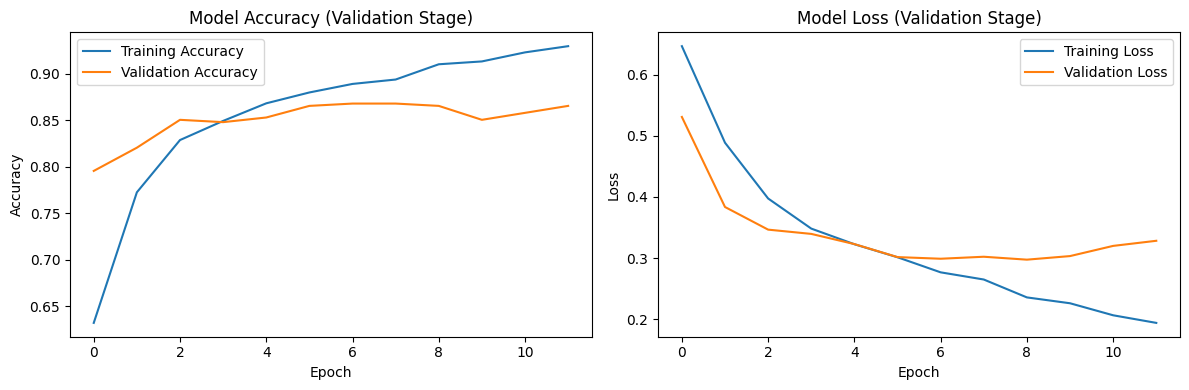

Retraining on full training set for 9 epochs...
Epoch 1/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5445 - loss: 0.6833
Epoch 2/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6849 - loss: 0.5979
Epoch 3/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7810 - loss: 0.4874
Epoch 4/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 0.4238
Epoch 5/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.3863
Epoch 6/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8647 - loss: 0.3594
Epoch 7/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.3483
Epoch 8/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8633 - loss: 0.3352
Epoch 9/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8866 - loss: 0.3097


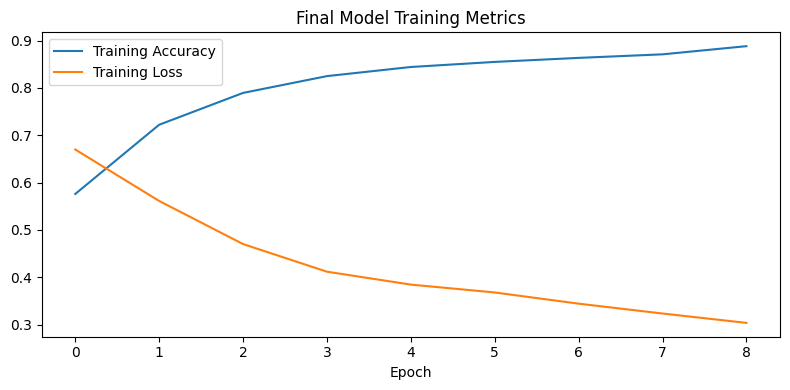

In [ ]:
# 1. Train with validation and early stopping to find best number of epochs
print("Finding best number of epochs with early stopping...")
model_val = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])
model_val.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_val = model_val.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)
# Find the best epoch
best_epoch = np.argmin(history_val.history['val_loss']) + 1
print(f"Best number of epochs found: {best_epoch}")

# Plot training and validation history after initial model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_val.history['accuracy'], label='Training Accuracy')
plt.plot(history_val.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Validation Stage)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_val.history['loss'], label='Training Loss')
plt.plot(history_val.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Validation Stage)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Retrain on the full training set for the best number of epochs, no validation
print(f"Retraining on full training set for {best_epoch} epochs...")
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 classes: literal and sarcastic
])
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    X_train, y_train,
    epochs=best_epoch,
    batch_size=32,
    verbose=1
)

# Plot only training metrics after retraining on full set
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Final Model Training Metrics')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,360 (313.91 KB)

 Trainable params: 26,786 (104.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,574 (209.28 KB)

In [ ]:
# Evaluate the model
print("Evaluating model...")
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Evaluating model...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report:
              precision    recall  f1-score   support

     literal       0.87      0.84      0.85       475
   sarcastic       0.86      0.88      0.87       526

    accuracy                           0.86      1001
   macro avg       0.86      0.86      0.86      1001
weighted avg       0.86      0.86      0.86      1001



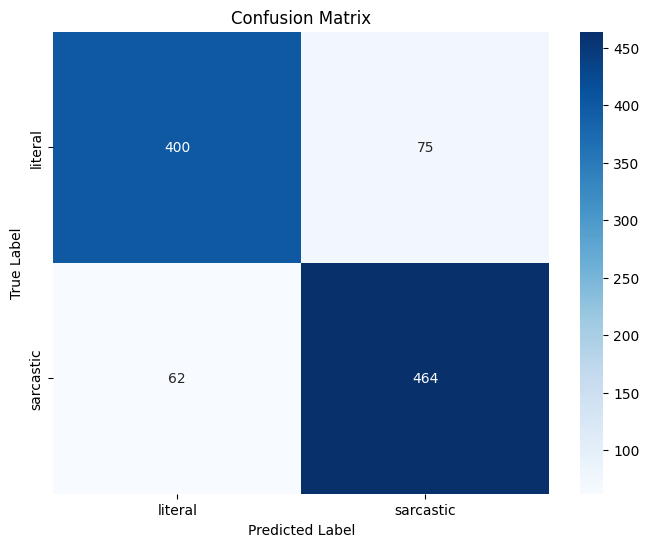

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');


In [ ]:
# Save the model and label encoder
print("Saving model and label encoder...")
model.save('tweet_classifier.h5')
import joblib
joblib.dump(le, 'label_encoder.joblib')
print("Model and encoder saved successfully!")


Saving model and label encoder...
Model and encoder saved successfully!


In [ ]:
# Display some example predictions
print("\nExample Predictions:")
test_examples = data.sample(n=5, random_state=42)
test_embeddings = ST_model.encode(test_examples['text'].tolist())
test_predictions_prob = model.predict(test_embeddings)
test_predictions = np.argmax(test_predictions_prob, axis=1)
test_predictions = le.inverse_transform(test_predictions)

for text, true_label, pred_label, pred_prob in zip(
    test_examples['text'],
    test_examples['label'],
    test_predictions,
    test_predictions_prob
):
    print(f"\nText: {text}")
    print(f"True label: {true_label}")
    print(f"Predicted label: {pred_label}")
    print(f"Prediction probability: {pred_prob[np.argmax(pred_prob)]:.3f}")
    print("-" * 80)


Example Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step

Text: Let's move to the rhythm of evening with fearless energy.
True label: literal
Predicted label: sarcastic
Prediction probability: 0.945
--------------------------------------------------------------------------------

Text: @Cupcake_Dollie Absolutely. I’m really happy you enjoyed spending time with me more.
True label: literal
Predicted label: literal
Prediction probability: 0.885
--------------------------------------------------------------------------------

Text: @therealtoriamos When will the UK iTunes codes be sent out? This process is frustrating. Please make ticket sales more straightforward next time.
True label: literal
Predicted label: literal
Prediction probability: 0.976
--------------------------------------------------------------------------------

Text: Trying to upload pictures of my friends, but it keeps failing.
True label: literal
Predicted label: literal
Prediction probability: 0.997
--------------